In [2]:
import joblib
import os
import torch
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import pickle
#embed = # numpy arrays

In [3]:
dirname = 'polyvore_outfits'
n_cluster = 20
mode = 'train'
#mode = 'test'
name = mode+'ing_set'

In [4]:
html_path = name + '_results.html'

In [5]:

image_path = os.path.join('../data/', dirname, 'images')
embeddings = np.load(os.path.join('../data', dirname , 'nondisjoint/'+mode+'_embeddings.npy'))
indexlist = pd.read_csv(os.path.join('../data', dirname,'nondisjoint/'+mode+'_embed_index.csv'))
data_json = os.path.join('../data', dirname, 'nondisjoint/'+mode+'.json') 
outfit_data = json.load(open(data_json, 'r'))

# load test embedding
raw_embeddings = embeddings



In [6]:
print(embeddings.shape)
print(raw_embeddings.shape)

(204679, 64)
(204679, 64)


In [7]:
print(image_path)

../data/polyvore_outfits/images


### generate type masks

In [8]:

type2idxs = {key: torch.LongTensor(len(indexlist)).zero_() for key in indexlist['type'].unique()}
for index, row in tqdm(indexlist.iterrows(), total=len(indexlist)):
    type2idxs[row['type']][index] = 1

100%|██████████| 204679/204679 [01:25<00:00, 2404.41it/s]


### generate positive pair ( in index )

In [ ]:
import os.path
if os.path.isfile(mode+'_pos_pair.pickle'):
    with open(mode+'_pos_pair.pickle','rb') as fp:
        pickle.load(pos_pairs, fp)
else:
    pos_pairs = []
    for outfit in tqdm(outfit_data):
        items = outfit['items']
        cnt = len(items)
        outfit_id = outfit['set_id']
        for j in range(cnt-1):
            for k in range(j+1, cnt):
                anc = int(items[j]['item_id'])
                anc_ind = indexlist[indexlist.image==int(anc)].index.values[0]
                pos = int(items[k]['item_id'])
                pos_ind = indexlist[indexlist.image==int(pos)].index.values[0]
                pos_pairs.append([outfit_id, anc_ind, pos_ind])
    # save pos pairs
    with open(mode+'_pos_pair.pickle','wb') as fp:
        pickle.dump(pos_pairs, fp)

 64%|██████▍   | 34106/53306 [29:59<17:29, 18.30it/s]  

In [ ]:
print(len(pos_pairs))

In [ ]:
types = indexlist['type'].unique()
#types = ['bottoms', 'tops']

In [ ]:
for mask_type in types:
    mask = type2idxs[mask_type]
    typeindex = indexlist.iloc[mask.nonzero().view(-1)]
    type_emb = raw_embeddings[mask.nonzero().view(-1)]
    
    #KNN predict
    type_, num = mask_type, n_cluster
    model = "{}_{}.joblib".format(type_, num)
    kmeans = joblib.load("./model/{}".format(model))
    pred = kmeans.predict(type_emb)
    
    indexlist.loc[mask.nonzero().view(-1), 'class'] = pred

In [ ]:
indexlist

In [ ]:
col = []
for _type in types:
    for i in range(n_cluster):
        col.append(_type+'_'+str(i))

In [ ]:
AdjMat = pd.DataFrame(np.zeros((len(types)*n_cluster, len(types)*n_cluster)), columns = col, index = col)

In [ ]:
AdjMat.head() # AdjMat[x][y]

In [ ]:
for (outfit_id, anc_ind, pos_ind) in tqdm(pos_pairs):
    
    anc_type = indexlist.iloc[anc_ind]['type']
    anc_class = indexlist.iloc[anc_ind]['class']
    anc_col = anc_type+'_'+str(int(anc_class))
    
    pos_type = indexlist.iloc[pos_ind]['type']
    pos_class = indexlist.iloc[pos_ind]['class']
    pos_col = pos_type+'_'+str(int(pos_class))
    
    AdjMat[anc_col][pos_col] += 1
    AdjMat[pos_col][anc_col] += 1
    

In [ ]:
AdjMat.head()

In [ ]:
AdjMat.to_csv(name+'_AdjacencyMatrix.csv')

In [ ]:
AdjMat.columns

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
count = 0
v_html = open(html_path, 'w')
img_width = str(300)

for row in tqdm(AdjMat.index):
    for col in AdjMat.columns:
        num = AdjMat[col][row]
        if(num>5):        
            
            atype = row.split('_')[0]
            aclass = int(row.split('_')[1])
            
            btype = col.split('_')[0]
            bclass = int(col.split('_')[1])
            if(atype==btype):
                continue
            if(not (atype=='tops' and btype=='bottoms')):
                continue
            count+=1
            
            v_html.write("<div id=\"image-table\"><table><tr>")
            
            amask = type2idxs[atype]
            aindexlist = indexlist.iloc[amask.nonzero().view(-1)]
            #print(aindexlist.head())
            aimages = aindexlist[aindexlist['class']==aclass].image.values
            achoice = np.random.choice(aimages, size=5)
            for imgid in achoice:
                imgpath = os.path.join(image_path, str(imgid)+'.jpg')
                img = mpimg.imread(imgpath)
                imgplot = plt.imshow(img)
                plt.show()
                v_html.write("<td style=\"padding:5px\">")
                v_html.write("<img src=\""+imgpath + "\" width=\"{}\">".format(img_width))
                v_html.write("<p style=\"text-align:center;font-size:30px;\">{}</p></td>".format(atype))
            
            bmask = type2idxs[btype]
            bindexlist = indexlist.iloc[bmask.nonzero().view(-1)]
            bimages = bindexlist[bindexlist['class']==bclass].image.values
            bchoice = np.random.choice(bimages, size=5)
            for imgid in bchoice:
                imgpath = os.path.join(image_path, str(imgid)+'.jpg')
                img = mpimg.imread(imgpath)
                imgplot = plt.imshow(img)
                plt.show()
                v_html.write("<td style=\"padding:5px\">")
                v_html.write("<img src=\""+imgpath + "\" width=\"{}\">".format(img_width))
                v_html.write("<p style=\"text-align:center;font-size:30px;\">{}</p></td>".format(btype))
                
            print('='*100)
            
            if count>500:
                break

### Plot

In [91]:
from numpy import genfromtxt
mydata = genfromtxt('testing_set_AdjacencyMatrix.csv', delimiter=',')

In [92]:
print(mydata)
print(type(mydata))
adjacency = mydata[1:,1:]
print(adjacency)
print(np.shape(adjacency))
n = n_cluster
adjacency = adjacency[6*n:8*n, 6*n:8*n]
print(np.shape(adjacency))

[[nan nan nan ... nan nan nan]
 [nan  2.  1. ...  5.  0.  0.]
 [nan  1.  2. ...  0.  0.  6.]
 ...
 [nan  5.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  6. ...  0.  0.  0.]]
<class 'numpy.ndarray'>
[[2. 1. 0. ... 5. 0. 0.]
 [1. 2. 1. ... 0. 0. 6.]
 [0. 1. 8. ... 1. 0. 0.]
 ...
 [5. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 6. 0. ... 0. 0. 0.]]
(220, 220)
(40, 40)


In [93]:
mylabel = {}
for i,c in enumerate(AdjMat.columns):
    mylabel.update({i: c})

In [94]:
#print(AdjMat.columns)
#print(types)
print(AdjMat.iloc[6*n:8*n, 6*n:8*n])

            bottoms_0  bottoms_1  bottoms_2  bottoms_3  bottoms_4  bottoms_5  \
bottoms_0         0.0        3.0        2.0        1.0        2.0        4.0   
bottoms_1         3.0       14.0        1.0        2.0        1.0        4.0   
bottoms_2         2.0        1.0       14.0        3.0        2.0        7.0   
bottoms_3         1.0        2.0        3.0       34.0        2.0        2.0   
bottoms_4         2.0        1.0        2.0        2.0       16.0        0.0   
bottoms_5         4.0        4.0        7.0        2.0        0.0       10.0   
bottoms_6         4.0        5.0       12.0        2.0        1.0        8.0   
bottoms_7         1.0        2.0        3.0        1.0        1.0        6.0   
bottoms_8         1.0        2.0        2.0        2.0        1.0        1.0   
bottoms_9         3.0        5.0        3.0        4.0        1.0        1.0   
bottoms_10        0.0        2.0        2.0        4.0        0.0        1.0   
bottoms_11        7.0        6.0        

In [95]:
ncolor = []
len_color = len(types)
len_color = 2
for i in range(len_color):
    ncolor = ncolor + [i]*n_cluster

In [96]:
ncolor

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [97]:
for k in adjacency:
    print(k)

[0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 2.
 0. 0. 0. 0. 3. 1. 0. 1. 0. 1. 3. 2. 0. 4. 0. 0.]
[0. 4. 0. 0. 1. 0. 1. 1. 0. 1. 2. 1. 0. 0. 0. 1. 0. 3. 2. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 0.]
[0. 0. 4. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 3. 0. 0. 3. 0. 1. 3. 1. 4.
 2. 2. 0. 0. 0. 3. 0. 2. 2. 0. 0. 1. 2. 0. 2. 1.]
[0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 3. 1. 0. 0. 2. 0.
 1. 0. 0. 0. 0. 0. 0. 2. 1. 1. 2. 3. 0. 2. 1. 4.]
[0. 1. 1. 0. 2. 0. 1. 1. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 2. 1. 1. 0. 1. 2. 1. 0. 0. 1. 0. 0. 2. 0. 1.]
[0. 0. 0. 0. 0. 2. 0. 0. 1. 0. 0. 0. 3. 1. 1. 0. 0. 0. 1. 0. 2. 0. 4. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 2. 0. 0. 2. 2. 0. 5.]
[ 0.  1.  0.  0.  1.  0.  2.  1.  0.  0.  0.  1.  0.  0.  2.  0.  0.  2.
  5.  0.  1.  1.  1.  1. 11.  0.  1.  0.  1.  1.  0.  2.  2.  2.  1.  2.
  0.  2.  4.  2.]
[1. 1. 0. 3. 1. 0. 1. 4. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 2. 2. 0. 0. 0. 0. 0. 0. 

[ 6 12 22 22 23 24 26 26 28 31 35 38]
[24 22 12 22 26  6 23 26 28 31 35 38]


ValueError: 'c' argument has 40 elements, which is not acceptable for use with 'x' with size 10, 'y' with size 10.

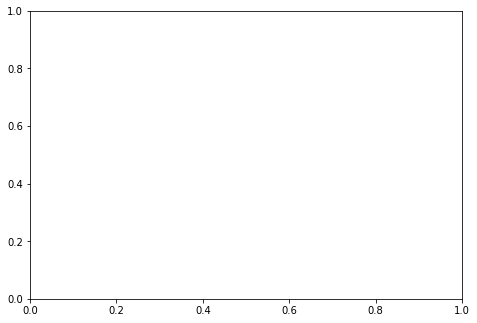

In [98]:
import matplotlib.pyplot as plt
import networkx as nx

def show_graph_with_labels(adjacency_matrix, mylabels):
    #rows, cols = np.where(adjacency_matrix == 1)
    rows, cols = np.where(adjacency_matrix > 10)
    print(rows)
    print(cols)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    #nx.draw(gr, node_size=500, labels=mylabels, with_labels=True)
    nx.draw(gr, node_color = ncolor ,pos=nx.spring_layout(gr), cmap=plt.cm.jet)
    plt.show()

show_graph_with_labels(adjacency, mylabel)

(-1.1220515648542688,
 1.1220515724040587,
 -1.1330773554420717,
 1.133077354597804)

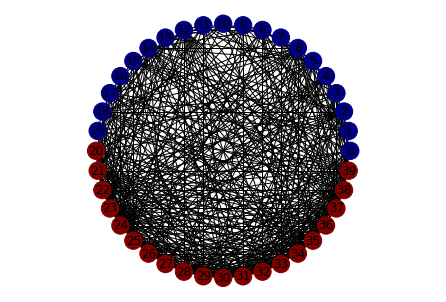

In [102]:
G2 = nx.from_numpy_matrix(adjacency)
nx.draw_circular(G2, node_color = ncolor , cmap=plt.cm.jet, with_labels=True)
plt.axis('equal')

In [ ]:
nx.draw(G, pos=nx.spring_layout(G))  #

In [44]:
AdjMat[AdjMat.columns=='tops_0']

,sunglasses_0,sunglasses_1,sunglasses_2,sunglasses_3,sunglasses_4,sunglasses_5,sunglasses_6,sunglasses_7,sunglasses_8,sunglasses_9,...,scarves_10,scarves_11,scarves_12,scarves_13,scarves_14,scarves_15,scarves_16,scarves_17,scarves_18,scarves_19
tops_0,9.0,16.0,14.0,18.0,6.0,20.0,10.0,16.0,13.0,68.0,...,4.0,1.0,3.0,3.0,33.0,11.0,1.0,4.0,1.0,1.0


In [39]:
sample = adjacency[40:50, 40:50]

In [40]:
sample = 1/sample

/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [41]:
sample

array([[       inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [       inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [       inf,        inf, 0.08333333,        inf,        inf,
        0.1       , 0.33333333, 0.33333333,        inf,        inf],
       [       inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [       inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf],
       [       inf,        inf, 0.1       ,        inf,        inf,
        0.125     , 0.2       , 0.5       ,        inf,        inf],
       [       inf,        inf, 0.33333333,        inf,        inf,
        0.2       , 0.16666667, 0.5       ,        inf,        inf],
       [       inf,        inf, 0.3333333

## single type 

In [35]:
mask_type = 'tops'

In [36]:
mask = type2idxs[mask_type]

In [37]:
indexlist.head()

,image,type
0,100005237,accessories
1,100015328,bags
2,100019428,bottoms
3,100020521,bags
4,100029428,bags


In [38]:
typeindex = indexlist.iloc[mask.nonzero().view(-1)]

In [39]:
typeindex.head()

,image,type
26,100159444,tops
33,100262409,tops
45,100403831,tops
49,100428043,tops
53,100457408,tops


In [40]:
raw_embeddings.shape

torch.Size([47854, 64])

In [41]:
raw_embeddings

tensor([[ 0.0263,  0.0235, -0.0913,  ...,  0.1594,  0.0030, -0.0761],
        [-0.0087, -0.0295, -0.0660,  ...,  0.0743,  0.0116,  0.0122],
        [-0.0449, -0.0033, -0.1001,  ...,  0.1252, -0.0136, -0.0191],
        ...,
        [-0.0422,  0.0234, -0.0445,  ...,  0.1411,  0.0033,  0.0129],
        [ 0.0029, -0.0566, -0.0908,  ...,  0.1854, -0.0367, -0.0120],
        [-0.0522, -0.0485, -0.0308,  ...,  0.0575, -0.0242, -0.0163]])

In [42]:
type_emb = raw_embeddings[mask.nonzero().view(-1)]

In [44]:
type_, num = mask_type, 10
model = "{}_{}.joblib".format(type_, num)
kmeans = joblib.load("./model/{}".format(model))
pred = kmeans.predict(type_emb)

/opt/python/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [45]:
pred

array([5, 9, 8, ..., 8, 8, 9], dtype=int32)

In [46]:
typeindex['class'] = pred

/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [47]:
typeindex.head()

,image,type,class
26,100159444,tops,5
33,100262409,tops,9
45,100403831,tops,8
49,100428043,tops,8
53,100457408,tops,2


In [66]:
indexlist.loc[mask.nonzero().view(-1), 'class'] = int(pred)

TypeError: only size-1 arrays can be converted to Python scalars

In [270]:
indexlist.tail()

,image,type
47849,99983742,shoes
47850,99984234,jewellery
47851,99985765,bags
47852,99989430,shoes
47853,99991996,jewellery


In [267]:
embeddings[26][-1]

tensor([ 0.1152,  0.0057, -0.1071,  0.0657,  0.0091,  0.1132, -0.0343, -0.0228,
        -0.0375,  0.0400,  0.0782, -0.0532,  0.0783,  0.0035, -0.0197, -0.0170,
         0.0131,  0.0281, -0.0128, -0.0403,  0.0046, -0.1328,  0.0304,  0.0756,
        -0.0318,  0.0016, -0.0025,  0.0323, -0.0431, -0.0180, -0.1734, -0.1197,
         0.0516,  0.0617,  0.0390, -0.0609, -0.1809, -0.0497,  0.0024,  0.0663,
         0.1160, -0.0076, -0.0314, -0.0777,  0.0524,  0.0255, -0.0400,  0.1152,
        -0.0150, -0.0021, -0.0131, -0.0142,  0.1328, -0.0763, -0.0003, -0.0544,
         0.1238,  0.0849, -0.1567, -0.0530,  0.0405, -0.0197,  0.0207,  0.0335])

In [266]:
len(embeddings)

204679